# [파이썬 머신러닝 완벽 가이드] <br>
# 03 평가 <br>
- 분류의 성능 평가 지표
    - 정확도 (Accuracy)
    - 오차행렬 (Confusion Matrix)
    - 정밀도 (Precision)
    - 재현율 (Recall)
    - F1 스코어
    - ROC AUC

## 03-1 정확도 (Accuracy) <br>
- `정확도 (Accuracy) = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수`

In [4]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    #fit() 메소드는 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    #predict() 메소드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
    def predict(self, X):
        pred = np.zeros( (X.shape[0],1) )
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [16]:
from sklearn import preprocessing

#Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

#머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

#레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

#앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv("C:/Users/kimhj/Desktop/ESAA/Data/titanic_train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

#위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test,mypredictions)))

Dummy Classifier의 정확도는: 0.7877


In [23]:
#레이블 값이 7인 것만 True, 나머지 값은 모두 False로 변환해 이진 분류 문제로 변경
#전체 데이터의 10%만 True, 나머지 90%는 False인 불균형한 데이터 세트로 변형

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    #입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros( (len(X),1), dtype=bool )
    
#사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

#digist 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

#불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습/예측/정확도 평기
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train,y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는: {:.3f}'.format(accuracy_score(y_test,fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는: 0.900


## 03-2 오차 행렬 <br>
- 오차행렬 (confustion matrix, 혼동행렬)
    - 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused) 있는지도 함께 보여주는 지표
    - 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표
    - 이진 분류에서 성능 지표로 잘 활용됨 
    <br>

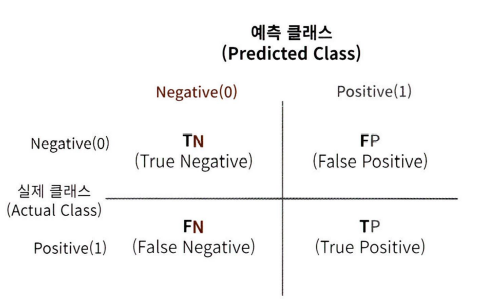
- TN (True Negative): 예측값을 Negative값 0으로 예측했고 실제값 역시 Negative값 0 → array[0,0]
- FP (False Positive): 예측값을 Positive값 1로 예측했는데 실제값은 Negative값 0 → array[0,1]
- FN (False Negative): 예측값을 Negative값 0으로 예측했는데 실제값은 Positive값 1 → array[1,0]
- TP (True Positive): 예측값을 Positive값 1로 예측했는데 실제값 역시 Positive값 1 → array[1,1]

In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,fakepred) #테스트 데이터 세트의 클래스값 분포는 0이 405건, 1이 45건

#TN: 전체 450건 데이터 중 무조건 Negative 0으로 예측해서 True가 된 결과 405건
#FP: Positive 1로 예측한 건수가 없으므로 0건
#FN: Positive 1인 건수 45건을 Negative로 예측해서 False가 된 결과 45건
#TP: Positive 1로 예측한 건수가 없으므로 0건

array([[405,   0],
       [ 45,   0]], dtype=int64)

- `정확도 = 예측 결과와 실제 값이 동일한 건수 / 전체 데이터 수 = (TN + TP) / (TN + FP + FN + TP)`

## 03-3 정밀도와 재현율 <br>
- `정밀도 = TP / (FP + TP)`
    - 예측을 Positive로 한 대상 중에 예측과 실제값이 Positive로 일치한 데이터의 비율
    - Positive 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표로 양성 예측도라고도 불림
    - 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되어 업무상 큰 영향이 발생하는 경우에 중요함
    - → 일반 메일을 스팸 메일로 분류하는 경우 
    - FP를 낮추는 데 초점을 맞춤 <br><br> 
- `재현율 = TP / (FN + TP)`
    - 실제값이 Positive인 대상 중에 예측과 실제값이 Positive로 일치한 데이터의 비율
    - 민감도(Sensitivity) 또는 TPR(True Positivie)라고도 불림
    - 실제 Positive 양성인 데이터 예측을 Negative 음성으로 잘못 판단하게 되어 업무상 큰 영향이 발생하는 경우에 중요함
    - → 암 양성인 환자를 음성으로 분류하는 경우
    - FN를 낮추는 데 초점을 맞춤

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy,precision,recall))

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv("C:/Users/kimhj/Desktop/ESAA/Data/titanic_train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)
lr_clf = LogisticRegression()

lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### [정밀도/재현율 트레이드오프] <br>
- 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉬움 <br>
    → 정밀도/재현율의 트레이드오프(Trade-off)로 부름 <br><br>
- predict_proba() 메소드
    - 개별 데이터별로 예측 확률을 반환하는 메소드
    - 반환되는 ndarray는 첫 번째 칼럼이 클래스값 0에 대한 예측 확률, 두 번째 칼럼이 클래스값 1에 대한 예측 확률임 <br><br>
    
[`ppredict_proba()` API]
- <입력 파라미터>  
    - predict() 메소드와 동일하게 보통 테스트 피처 데이터 세트를 입력 <br>

- <반환 값>
    - 개별 클래스의 예측 확률을 ndarray m x n (m: 입력 값의 레코드 수, n: 클래스 값 유형) 형태로 반환
    - 입력 테스트 데이터 세트의 표본 개수가 100개이고 예측 클래스 값 유형이 2개(이진 분류)라면 반환 값은 100 x 2 ndarray임
    - 각 열은 개별 클래스의 예측 확률임
    - 이진 분류에서 첫 번째 칼럼은 0 Negative의 확률, 두 번째 칼럼은 1 Positive의 확률임

In [32]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출: \n',pred_proba[:3])

#예측 확률 array와 예측 결과값 array를 병합(concatenate)해 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)],axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])

pred_proba() 결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출: 
 [[0.46170212 0.53829788]
 [0.87864222 0.12135778]
 [0.87728507 0.12271493]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46170212 0.53829788 1.        ]
 [0.87864222 0.12135778 0.        ]
 [0.87728507 0.12271493 0.        ]]


In [33]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
    [2,0,0],
    [0,1.1,1.2]]

#X의 개별 원소들이 threshold(임계값)값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [35]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값, 분류 결정 임계값임
custom_threshold = 0.5

#predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test,custom_predict) 

#이 코드로 계산된 평가 지표가 앞 예제의 타이타닉 데이터로 학습된 로지스틱 회귀 Classifier 객체에서 호출된 predict()로 계산된 지표 값과 같음
#predixt()가 predict_proba()에 기반함을 알 수 있음

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [37]:
#Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임계값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)
get_clf_eval(y_test,custom_predict) 

오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361


- 임계값을 낮추니 재현율이 올라가고 정밀도가 떨어짐
- 분류 결정 임계값은 Positive 예측값을 결정하는 확률의 기준임
    → 확률이 0.5가 아닌 0.4부터 Positive로 예측을 더 너그럽게 하기 때문에 임계값을 낮출수록 True값이 많아지게 됨
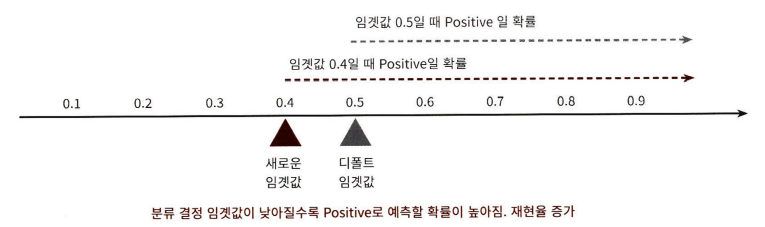

In [42]:
#테스트를 수행할 모든 임계값을 리스트 객체로 저장
thresholds = [0.4,0.45,0.5,0.55,0.6]

def get_eval_by_threshold(y_test,pred_proba_c1,thresholds):
    #thresholds list 객체 내의 값을 차례로 iteration하면서 Evalution 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값:',custom_threshold)
        get_clf_eval(y_test,custom_predict)
        print("\n")
        
get_eval_by_threshold(y_test,pred_proba[:,1].reshape(-1,1),thresholds)

임계값: 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361


임계값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033


임계값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


임계값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541


임계값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377




[`precision_recall_curve()` API]
- <입력 파라미터>  
    - y_trud: 실제 클래스값 배열 (배열 크기 = [데이터 건수])
    - probas_pred: Positive 칼럼의 예측 확률 배열 (배열 크기 = [데이터 건수]) <br>

- <반환 값>
    - 정밀도: 임계값별 정밀도 값을 배열로 반환
    - 재현율: 임계값별 재현율 값을 배열로 반환

In [45]:
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 Shape:', thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임계값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값:', np.round(thresholds[thr_index],2))

#15 Step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index],3))

#임계값이 증가할수록 정밀도 값도 증가하나 재현율 값은 감소함

반환된 분류 결정 임계값 배열의 Shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값: [0.1  0.12 0.14 0.19 0.28 0.4  0.57 0.67 0.82 0.95]
샘플 임계값별 정밀도: [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율: [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


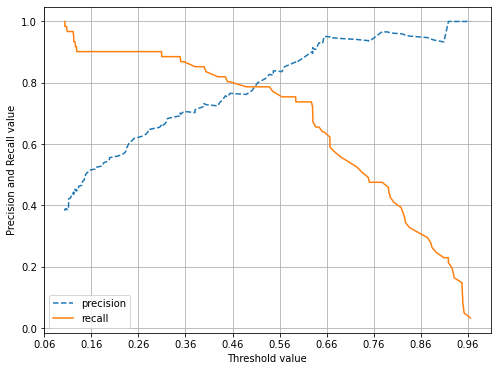

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def precision_recall_curve_plot(y_test,pred_proba_c1):
    #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    #X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary],linestyle='--',label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    #threshold 값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    #x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

#임계값이 낮을수록 많은 수의 양성 예측으로 인해 재현율 값이 극도로 높아지고 정밀도 값이 극도로 낮아미
#앞 예제의 로지스틱 회귀 기반의 타이타닉 생존자 예측 모델의 경우 임계값이 약 0.45 지점에서 재현율과 정밀도가 비슷해지는 모습을 보임

### [정밀도와 재현율의 맹점] <br>

- 정밀도가 100%가 되는 방법
    - 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측함
    - 예) 환자가 80세 이상이고 비만이며 이전에 암 진단을 받았고 암 세포의 크기가 상위 0.1% 이상이면 Positive, 아니면 Negative로 예측
    
- 재현율이 100%가 되는 방법
    - 모든 환자를 Positive로 예측함 <br><br>
- → 정밀도와 재현율의 수치가 적절하게 조합돼 분류의 종합적인 성능 평가에 사용될 수 있는 평가 지표가 필요함

## 03-4 F1 스코어 <br>
- `F1 = 2 / (1/recall + 1/precision) = 2* ( (precision*recall) / (precision + recall) )`

In [49]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test,pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [53]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    #F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    #f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy,precision,recall,f1))
    
thresholds = [0.4,0.45,0.5,0.55,0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

#F1 스코어는 임계값이 0.6일 때 가장 좋은 값을 보여주지만 임계값이 0.6인 경우에는 재현율이 크게 감소하고 있음

임계값: 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361, F1: 0.7786


임계값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1: 0.7840


임계값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805


임계값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1: 0.7931


임계값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1: 0.8036




## 03-5 ROC 곡선과 AUC <br>
- ROC 곡선 (Receiver Operation Characteristic Curve)
    - FPR (False Positive Rate)이 변할 때 TPR (True Positive Rate)이 어떻게 변하는지를 나타내는 곡선임
    - FPR을 X축으로, TPR을 Y축으로 잡으면 FPR의 변화에 따른 TPR의 변화가 곡선 형태로 나타남 <br>
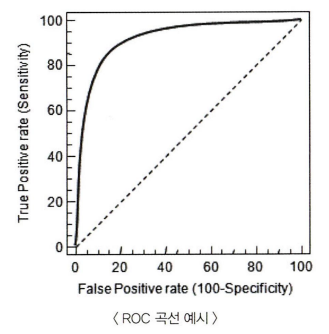 <br><br>
- `민감도 (TPR, Sensitivity)`: 실제값 Positive(양성)가 정확히 예측되어야 하는 수준을 나타냄 
    - → 질병이 있는 사람은 질병이 있는 것으로 양성 판정
- `특이성 (TNR, Specivity)`: 실제값 Negative(음성)가 정확히 예측되어야 하는 수준을 나타냄
    - → 질병이 없는 건강한 사람은 질병이 없는 것으로 음성 판점 <br><br>
- `TNR (True Positive Rate) = TN / (FP + TN)`
- `FPR (False Positive Rate) = FP / (FP + TN) = 1 - TNR`

[`roc_curve()` API]
- <입력 파라미터>  
    - y_trud: 실제 클래스값 array (array shape = [데이터 건수])
    - y_score: predict_proba()의 반환 값 array에서 Positive 칼럼의 예측 확률이 보통 사용됨 (array shape = [n_samples]) <br>

- <반환 값>
    - fpr: fpr 값을 array로 반환
    - tpr: tpr 값을 array로 반환
    - thresholds: threshold 값 array

In [54]:
from sklearn.metrics import roc_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
#반환된 임계값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임계값을 5 Step으로 추출
#thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1,thresholds.shape[0],5)

print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값:', np.round(thresholds[thr_index],2))

#5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR: ', np.round(fprs[thr_index],3))
print('샘플 임계값별 TPR: ', np.round(tprs[thr_index],3))

샘플 추출을 위한 임계값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임계값: [0.97 0.65 0.63 0.57 0.45 0.38 0.31 0.13 0.12 0.11 0.1 ]
샘플 임계값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.186 0.237 0.576 0.619 0.754 0.814]
샘플 임계값별 TPR:  [0.033 0.639 0.705 0.754 0.803 0.852 0.902 0.902 0.951 0.967 1.   ]


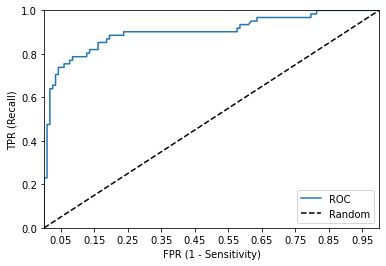

In [56]:
def roc_curve_plot(y_test, pred_proba_c1):
    #임계값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    #ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')
    #가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],'k--',label='Random')
    
    #FPR X축의 Scale을 0.1 단위로 변경, X,Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR (1 - Sensitivity)')
    plt.ylabel('TPR (Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

- 일반적으로 ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는데 이용하며 분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC 값으로 결정함
- AUC (Area Under Curve): ROC 곡선 밑의 면적을 구한 것으로 일반적으로 1에 가까울수록 좋은 수치임

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_target,preds))
print('정확도: ', np.round(accuracy_score(y_target,preds),4))
print('정밀도: ', np.round(precision_score(y_target,preds),4))
print('재현율: ', np.round(recall_score(y_target,preds),4))

In [62]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    #ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    #ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))